# Lab Assignment: (A) Predictive Modeling of Drug Dosage

In this exercise, you will learn to predict the most likely efficacious drug dosage based on several patient factors, such as height, weight, age and the genotypes at certain genes. This exercise is based on the results of The International Warfarin Pharmacogenetics Consortium __2009__, "Estimation of the Warfarin Dose with Clinical and Pharmacogenetic Data", _N. Engl. J. Med_, 360, Pgs. 753-764 (data was downloaded from https://www.pharmgkb.org/downloads). The authors create a model for warfarin dosage predictions based on clinical data and the genotypes of individuals at two genes. 

The lab assignment will explore preprocessing of the data, the creation of a predictive model based on linear regression and regularization 

## Preprocessing of the data

In [0]:
from sklearn import preprocessing,decomposition,linear_model
import plotnine as p9
import pandas as pd

In [0]:
#google drive connection
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Examine the data
First, take a look at the original data file to get a sense of the unprocessed data columns.

In [0]:
data_unprocessed = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/Warfarin_Study.txt", sep="\t")
data_unprocessed.head()

PharmGKB Subject ID  Gender  ... Phenytoin (Dilantin) Rifampin or Rifampicin
0         PA135312261    male  ...                  NaN                    NaN
1         PA135312262  female  ...                  NaN                    NaN
2         PA135312263  female  ...                  NaN                    NaN
3         PA135312264    male  ...                  NaN                    NaN
4         PA135312265    male  ...                  NaN                    NaN

[5 rows x 22 columns]

Next, examine the processed data file.

In [0]:
data_processed = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/Warfarin_Study_train.txt", sep="\t")
data_processed.head()

Therapeutic.Dose.of.Warfarin  Height..cm.  ...  CYP2C9_3_3  CYP2C9_Missing
0                          23.0       160.02  ...           0               0
1                          49.0       181.61  ...           0               0
2                          30.0       173.99  ...           0               0
3                          56.0       172.72  ...           0               0
4                          51.0       182.88  ...           0               0

[5 rows x 18 columns]

Note that many of the columns have been processed already in the interests of time. Especially pay attention to the recoding of the categorical variables associated with the genotypes. For example, the rs9923231 SNP associated with gene _VKORC1_ encodes a G -> A mutation, and so there are four possible genotypic categories (with no associated quantitative measure): G/G, G/A, A/A, Missing. If the non-mutated, homozygous state G/G is treated as the reference state, the others are encoded by a so-called "one-hot" enoding strategy. In this encoding, for $\textit{N}$ categories, $\textit{N-1}$ new variables are created for all the non-reference states; when a category is observed, the corresponding variable has a value of 1, while all the others are set to 0. When the reference category is observed, all the variables are set to 0.  


### Shifting and Scaling of the data

In this step, you will shift and scale the data in all the continuous-valued columns by two different transformations:

First try "Standard Scaling":
\begin{equation*} x_{i} \to \frac{x_{i} - \mu}{\sigma}, \end{equation*} where $\mu$ is the mean and $\sigma$ is the standard deviation of the data. This is done to ensure that the scales of all the expression values are about the same, and thus prevents biases in the weight attached to a given variable, simply because its magnitude happens to be larger or smaller on average. These shifted and rescaled values are the so-called Z-scores of the data.

Next, try "MinMax Scaling":
\begin{equation*} x_{i} \to \frac{x_{i} - min(x_{i})}{max(x_{i}) - min(x_{i})}, \end{equation*} where $max(x_{i})$ is the maximum value of the data series and $min(x_{i})$ is the minimum value of the data series.

These are two different ways of scaling. The "standardization" procedure in the first method is very commonly used, but distorts the distribution a little bit. The min-max scaling procedure retains the distribution, and confines the range to be within 0 and 1. There is no definitive prescription for what is best, so trying both can be helpful. 

In [0]:
# load the training data, with the y matrix being assigned the 'Therapeutic.Dose.of.Warfarin' data, and the x matrix being assigned
# all the other columns except for 'Therapeutic.Dose.of.Warfarin' 
trainset = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/Warfarin_Study_train.txt", sep="\t")
y_train = trainset['Therapeutic.Dose.of.Warfarin']
x_train = trainset.drop('Therapeutic.Dose.of.Warfarin', axis=1)

# load the test data, with the y matrix being assigned the 'Therapeutic.Dose.of.Warfarin' data, and the x matrix being assigned
# all the other columns except for 'Therapeutic.Dose.of.Warfarin' 
testset = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/Warfarin_Study_test.txt",sep="\t")
y_test = testset['Therapeutic.Dose.of.Warfarin']
x_test = testset.drop('Therapeutic.Dose.of.Warfarin', axis=1)


In [0]:
#### Create a 'StandardScaler()' object
####------>
scaler_obj = preprocessing.StandardScaler()

# Create a list of the columns you want to normalize
to_normalize = ['Height..cm.', 'Weight..kg.', 'Age_Decades']

####Here we create a separate copy of the original training and test data, so that any modifications
#### to the new copy are not transferred back to the original matrix 
####(this would happen if we set the x_ss_train = x_train)
x_ss_train = x_train.copy()
x_ss_train[to_normalize] = scaler_obj.fit_transform(x_ss_train[to_normalize])

x_ss_test = x_test.copy()
x_ss_test[to_normalize] = scaler_obj.fit_transform(x_ss_test[to_normalize])

In [0]:
#### Run MinMax Scaling
minmax_obj = preprocessing.MinMaxScaler()
x_mm_train = x_train.copy()
x_mm_train[to_normalize] = minmax_obj.fit_transform(x_mm_train[to_normalize])

x_mm_test = x_test.copy()
x_mm_test[to_normalize] = minmax_obj.fit_transform(x_mm_test[to_normalize])

### Linear regression model

#### Unscaled data

In [0]:
#### Create a 'LinearRegression()' object from the 'linear_model' class
regr = linear_model.LinearRegression()

####Fit the x_train_arr data to the square root of the y_train_arr data using the 'fit' function
####In this case, we chose to take the square root of the target output data to match the
#### method of the original paper; in general, you may consider transforming your target data and feature 
#### data in different ways to better fit the model
####------>
regr.fit(x_train, y_train ** (1./2))

####Print out the fit coefficients and intercept
print(regr.coef_)
print(regr.intercept_)

[ 0.01187106  0.01317074 -0.23686162 -0.57034589  1.16519373 -0.16687181
 -0.15441854 -0.18021427 -0.84610236 -1.68836373 -0.63966833 -0.48231671
 -0.8303828  -0.99716393 -1.93056185 -2.09245817 -0.49839203]
4.903674669504408


In [0]:
#### Test the model by finding the score using the 'score' function; remember to use the square root of 
####the test set
####------>
regression_score = regr.score(x_test, y_test ** (1./2))
print(regression_score)

####Find the prediction values of the model explicitly; this step is mainly for the plotting function below.
y_predict = regr.predict(x_test)

0.429307232660645


#### Standard Scaling

In [0]:
#### Create a 'LinearRegression()' object from the 'linear_model' class
regr = linear_model.LinearRegression()

#### Fit the x_train_arr data to the square root of the y_train_arr data using the 'fit' function
#### In this case, we chose to take the square root of the target output data to match the
#### method of the original paper; in general, you may consider transforming your target data and feature 
#### data in different ways to better fit the model
####------>
regr.fit(x_ss_train, y_train ** (1./2))

####Print out the fit coefficients and intercept
print(regr.coef_)
print(regr.intercept_)

[ 0.12830048  0.29267718 -0.34494393 -0.57034589  1.16519373 -0.16687181
 -0.15441854 -0.18021427 -0.84610236 -1.68836373 -0.63966833 -0.48231671
 -0.8303828  -0.99716393 -1.93056185 -2.09245817 -0.49839203]
6.526938003775576


In [0]:
#### Test the model by finding the score using the 'score' function; remember to use the square root of 
####the test set
####------>
regression_score = regr.score(x_ss_test, y_test ** (1./2))
print(regression_score)

####Find the prediction values of the model explicitly; this step is mainly for the plotting function below. 
y_ss_predict = regr.predict(x_ss_test)

0.4290141910849038


#### **(Optional)** MinMax Scaling

In [0]:
#### Create a 'LinearRegression()' object from the 'linear_model' class
regr = linear_model.LinearRegression()

####Fit the x_train_arr data to the square root of the y_train_arr data using the 'fit' function
####In this case, we chose to take the square root of the target output data to match the
#### method of the original paper; in general, you may consider transforming your target data and feature 
#### data in different ways to better fit the model
regr.fit(x_mm_train, y_train ** (1./2))


####Print out the fit coefficients and intercept
print(regr.coef_)
print(regr.intercept_)

[ 0.91442811  2.7355627  -1.89489293 -0.57034589  1.16519373 -0.16687181
 -0.15441854 -0.18021427 -0.84610236 -1.68836373 -0.63966833 -0.48231671
 -0.8303828  -0.99716393 -1.93056185 -2.09245817 -0.49839203]
6.545462209702442


In [0]:
#### Test the model by finding the score using the 'score' function; remember to use the square root of 
####the test set
####------>
regression_score = regr.score(x_mm_test, y_test ** (1./2))
print(regression_score)

####Find the prediction values of the model explicitly; this step is mainly for the plotting function below. 
y_mm_predict = regr.predict(x_mm_test)

0.4117745843836391


### Plot the results: first plot the fit to the original dosage, without the square root transformation; then plot the fit to the transformed dosage data.

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


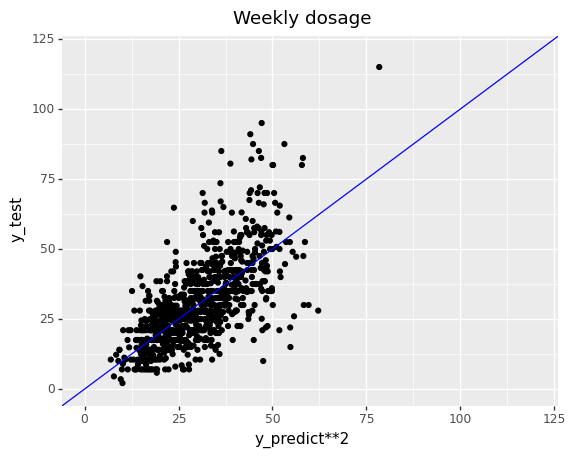

<ggplot: (8787019805995)>

In [0]:
(
    p9.ggplot(pd.DataFrame({"y_predict**2": y_predict ** 2, "y_test": y_test}))
      + p9.geom_point(p9.aes(x="y_predict**2",y="y_test"), color="black")
      + p9.geom_abline(intercept=0, slope=1, color='blue')
      + p9.ggtitle('Weekly dosage')
      + p9.xlim(0, 120)
      + p9.ylim(0, 120)
)

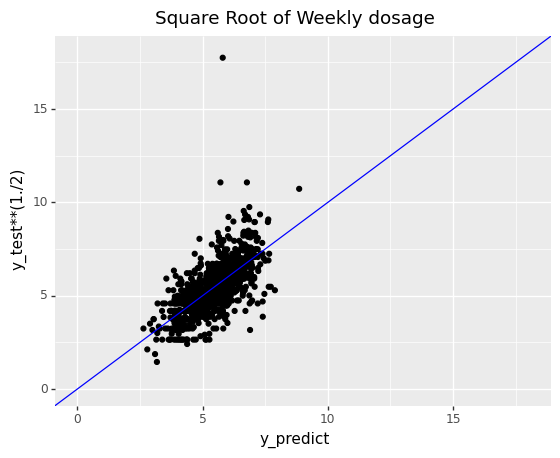

<ggplot: (-9223363249835328964)>

In [0]:
(
    p9.ggplot(pd.DataFrame({"y_predict": y_predict, "y_test**(1./2)": y_test**(1./2)}))
      + p9.geom_point(p9.aes(x="y_predict",y="y_test**(1./2)"), color="black")
      + p9.geom_abline(intercept=0, slope=1, color='blue')
      + p9.ggtitle('Square Root of Weekly dosage')
      + p9.xlim(0, 18)
      + p9.ylim(0, 18)
)

# Lab Assignment: (B) Multiclass Classification

We will now explore a multiclass classification problem using data from PsychENCODE.  The following example is based on RNAseq gene expression data from post-mortem Prefrontal Cortex samples of control subjects, and subjects with Schizophrenia, Bipolar disorder and Autism.

## Import the necessary libraries

In [0]:
from sklearn.ensemble import RandomForestClassifier

## Load the PsychENCODE data

In [0]:
train = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/pec_traindata.csv", header=None)
test = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/pec_testdata.csv", header=None)

## Extract training data, and learn a Random Forest classifier

The training and test data matrices each contain 200 predictor genes (columns 0-199) and class labels 0-3 in the final column.  Classes are: 0 = Controls, 1 = Schizophrenia, 2 = Bipolar, 3 = Autism.  15 subjects from each class are included in training and testing sets.  Use a forest with 20 trees of maximum depth 4.

In [0]:
test.head()

0        1         2         3    ...      197     198       199  200
0  0.729270 -0.61931 -0.681020 -1.114600  ... -0.39821  1.1243  0.631140    0
1 -2.060600  0.81312 -0.127490  1.684300  ...  1.04040  0.4293 -0.097461    0
2  0.620090  1.31690 -0.324790 -0.385600  ...  1.53730  1.4301 -0.734350    0
3  0.498670 -0.38281 -0.109200 -0.098113  ...  0.63114  1.1668 -2.419800    0
4 -0.081829  1.93660  0.064917 -0.447160  ...  1.95380  1.2266  0.111810    0

[5 rows x 201 columns]

In [0]:
y = train[200]
X = train.drop(200, axis=1)
#### Initialize a RandomForestClassifier object, with 20 trees (n_estimators), each of maximum depth 4, while passing 
#### 'random_state=0' as an argument for repeatability.  
####------> 
clf = RandomForestClassifier(n_estimators=20, max_depth=4, random_state=0)
#### Then, call the 'fit' method on the classifier object to
#### train it using X and y as above
clf.fit(X, y)

NameError: ignored

## Extract test data, and apply classifier

In [0]:
X2 = test.drop(200, axis=1)
y2 = test[200]
#### Calculate predictions on the test set by calling the 'predict' method on the trained RandomForestClassifier 
####------> 
y_pred2 = clf.predict(X2)

## Generate and plot the confusion matrix, and calculate accuracy

Confusion matrix:
[[5 3 4 0]
 [1 6 4 2]
 [4 3 6 4]
 [5 3 1 9]]
Overall accuracy: 0.433


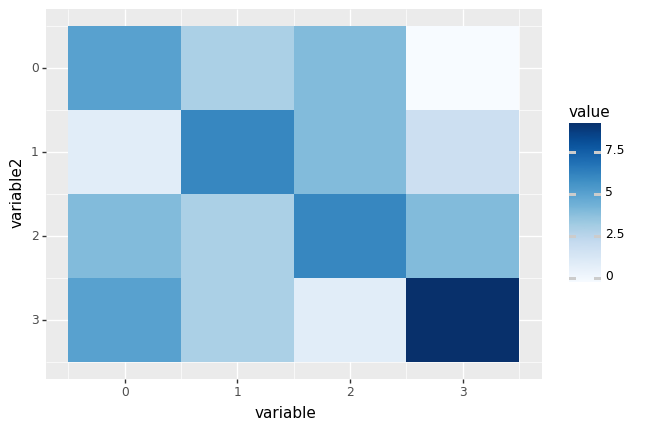

<ggplot: (8787016886732)>

In [0]:
from sklearn.metrics import confusion_matrix
#### Use the 'confusion_matrix' function to calculate the confusion matrix for the ground truth and predicted outputs
#### on the test data
####------> 
cm = confusion_matrix(y_pred2, y2)

####Build a data frame to help the plotting below
cm_melt = {"variable":[],"variable2":[],"value":[]}
for column,value in pd.DataFrame(cm).items():
    cm_melt['value']+=value.tolist()
    cm_melt['variable2'] += range(len(value))
    cm_melt['variable']+=[column]*len(value)
cm_melt = pd.DataFrame(cm_melt)

print("Confusion matrix:")
print(cm)

#### Evaluate overall accuracy using the trace of the confusion matrix; the trace is the sum over the main diagonal elements
####------>  
acc = 0
for i in range(len(cm)):
  acc = acc + cm[i][i]

####Normalize the trace by the total number of individuals in the study to get the accuracy
acc = acc / len(train)
print("Overall accuracy: " + f"{acc:.3f}")

(
    p9.ggplot(cm_melt)
      + p9.geom_tile(p9.aes(x = "variable", y = "variable2",fill="value"))
      + p9.scale_fill_continuous("Blues")
      + p9.scales.scale_y_reverse()
)

## Find most important genes, and plot per-class correlations

Use the attribute 'feature_importances_' of the random forest classifier, and rank the genes by this value.  Use the .corr method to calculate the Pearson correlation of the top 10 genes with each class.

Most important genes:
143     ENSG00000121594.7
176     ENSG00000105879.7
184     ENSG00000079459.8
44     ENSG00000165973.13
161     ENSG00000197914.2
193     ENSG00000187690.2
134     ENSG00000128322.6
42      ENSG00000181001.1
61      ENSG00000111537.4
144    ENSG00000065534.14
Name: genes, dtype: object


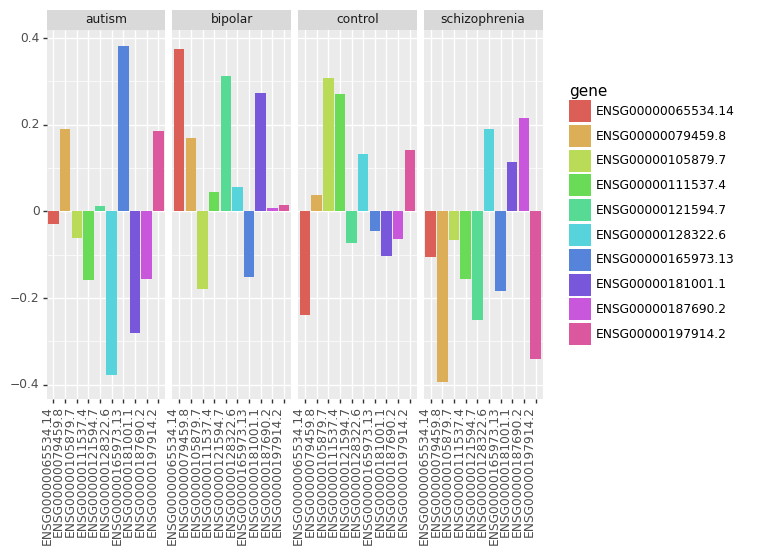

<ggplot: (8787016829893)>

In [0]:
geneIds = pd.read_csv('/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/GeneNames_PEC_filtered.txt', header=None, names=['genes'])

print("Most important genes:")

#### Use the method 'feature_importances_' from the RandomForestClassifier class to 
#### get the importance of each feature.
####Take the absolute value of the feature importances 
geneIds['importance'] = abs(clf.feature_importances_)

#### The values need to be ordered such that the genes with largest coefficients are listed first
geneIds = geneIds.sort_values(by='importance', ascending=False).head(10)
print(geneIds['genes'])

#### Calculate the correlation between the expression of every one of the top 10 genes across individuals with a binary indicator vector
#### (y==j) for class j.
arr = {"class":[], "corr":[], "gene":[]}
for i, data in geneIds.iterrows():
    arr["gene"] += [data['genes']]*4
    arr["class"] += range(4)
    for j in range(4):
      arr['corr'].append(X[i].corr(y==j))
  
# names for the class values
class_names = {0:"control", 1:"schizophrenia", 2:"bipolar", 3:"autism"}

(
    p9.ggplot(pd.DataFrame(arr).replace({'class': class_names}))
      + p9.geom_bar(p9.aes(x="gene",y="corr", fill="gene"),stat="identity")
      + p9.labs(x="", y="")
      + p9.facet_wrap("class", nrow=1) 
      + p9.theme(axis_text_x = p9.element_text(angle = 90, hjust = 1))
)